<br>Ozu Woodroffe
<br>CMSC320
<br>Fall 2022

<center><h1 style= \"font-size:24;\">Shark Attacks - Australia </h1></center>
<hr>


## Introduction:
There are many ordinary and normal dangers to be found in the ocean, such as the threat of drowning. However sharks are constantly pushed by our pop-culture as a sinister apex predator, recognizing [their mere presence as newsworthy](https://www.dailymail.co.uk/news/article-11539287/Mullaloo-Beach-Perth-closed-second-day-two-massive-tiger-sharks-spotted-close-shore.html). The most common tip for avoiding a shark bite is to punch the shark in the nose, which is not a practical solution for anyone. With the constant media attention given to sharks, there is a demand for more thoughtful advice.

Using actual data of shark attacks from the past century, I will analyze which factors cause these attacks and how you can best avoid becoming a target. Hopefully, this will help assuage a common fear of the open water, or allow people to plan their vacations to Australian coast to be as attack-free as possible.
<br><b>By the end of this tutorial, you will be able to:</b>
<br>
- Collect and organize data from a csv file
- Summarize the data
- Visualize the data using maps and graphs
- Create Regression models of the data
    

## Libraries:

<b>In this tutorial, we will be using:</b><br>
- For data collection:
    - the [Pandas](https://pandas.pydata.org/pandas-docs/stable/#) library.
    - [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) for extracting data from HTMLs
    - [requests](https://pypi.org/project/requests/) to get the HTML
- For graphing:
    - The [pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) interface for matplotlib
    - The [Seaborn](https://seaborn.pydata.org/) library
- For modeling
    - The statsmodels api
    - sklearn
- For mapping:
    - The [Folium](https://python-visualization.github.io/folium/) library
- Other:
    - numpy

In [1]:
import numpy as np

import pandas as pd
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn import datasets, metrics, model_selection
from sklearn.ensemble import RandomForestClassifier 

import folium

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## The Data:
### About the Data: 
This tutorial will use the [Australian Shark-Incident Database (ASID)](https://taronga.org.au/conservation-and-science/australian-shark-incident-database) provided by Toranga Conservation Society in Australia for the majority of calculations.
<br>To add context, a table of [coastline information](https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths) and [population information](https://www.abs.gov.au/statistics/people/population/population-census/2021) provided by the Austraian governement.

### Reading in the Data: 
Now, the data will be read in and generally tidied up.
<br>Population information and the shark attack data table will be read in from the /data folder, and the coastline information will be read from the site directly.

#### Coastline Information
The following data will first be read in using requests.get, 
<br>Then it will be parsed into a BeautifulSoup object
<br>This object will then be searched for data. The markers for where your data is will differ from site to site, but usually searching for 'table' will help you get to the right area. In this table, each cell is marked with 'td'

In [2]:
#Request the data
res_obj = requests.get('https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths')
coast_soup = BeautifulSoup(res_obj.text,'html.parser')
#print(pop_info.prettify()) #To display the raw html

#find entries in html table
coast_rows=[]
for td in coast_soup.find_all('td'):
    coast_rows.append(td.get_text(strip=True))
coast_rows.remove('Length Kilometres')
cols=coast_rows[:5]
coast_rows=coast_rows[5:]

#collect the values into 5 lists: 1 for each variable
c_r=[[],[],[],[],[]]
for i in range(10):
    for x in range(5):
        c_r[x].append(coast_rows[x+(5*i)])
        
#create dataframe
coast_info=pd.DataFrame(columns=cols)
for a in range(5):
    coast_info[cols[a]]=c_r[a]

Next, each numerical variable should be cast from a string to an integer value. I will place '-1' in the empty cells until I can change it to NaNs.

In [3]:
# Replace all "-" placeholders with -1
coast_info.replace(to_replace='-', value="-1", inplace=True)
#Remove spaces and convert to int
coast_info['LAND BORDER LENGTH']=(coast_info['LAND BORDER LENGTH'].str.replace(' ','')).astype(int)
coast_info['MAINLAND COASTLINE LENGTH']=(coast_info['MAINLAND COASTLINE LENGTH'].str.replace(' ','')).astype(int)
coast_info['ISLAND LENGTH']=(coast_info['ISLAND LENGTH'].str.replace(' ','')).astype(int)
coast_info['TOTAL COASTLINE LENGTH']=(coast_info['TOTAL COASTLINE LENGTH'].str.replace(' ','')).astype(int)
#replace the -1 placeholders with NaN
coast_info.replace(to_replace=-1, value=np.NaN, inplace=True)
#drop trailing rows
coast_info.drop(index=[7,8,9], inplace=True)
coast_info.set_index("State/Territory", inplace=True)
coast_info

,LAND BORDER LENGTH,MAINLAND COASTLINE LENGTH,ISLAND LENGTH,TOTAL COASTLINE LENGTH
State/Territory,,,,
Western Australia,1874.0,12895.0,7894.0,20788.0
Queensland,3337.0,6967.0,6385.0,13352.0
Northern Territory,3180.0,5438.0,5516.0,10954.0
South Australia,3187.0,3815.0,1244.0,5059.0
Tasmania,NaN,2827.0,2046.0,4872.0
Victoria,2550.0,1870.0,645.0,2515.0
New South Wales,4625.0,1973.0,128.0,2101.0


#### Population data:
population data should be read from the file:

In [4]:
pop_info = pd.read_csv("data/Count of persons(a) by state and territory by sex, 2021 Census.csv", sep=',')

The data above seemed to export well, besides a few rows of NaNs. Remove them, and then change each value from string to int

In [5]:
pop_info=pop_info.dropna()
#Drop trailing rows
pop_info.drop(index=[7,8], inplace=True)
#Set index to the reigon
pop_info.set_index("Reigon", inplace=True)
#remove commas from strings elements, convert to int
pop_info["Total"]=pop_info["Total"].str.replace(',','').astype(int)
pop_info["Male"]=pop_info["Male"].str.replace(',','').astype(int)
pop_info["Female"]=pop_info["Female"].str.replace(',','').astype(int)
pop_info

,Male,Female,Total
Reigon,,,
New South Wales,3984166,4087995,8072163
Victoria,3200963,3302528,6503491
Queensland,2540404,2615736,5156138
South Australia,878592,902924,1781516
Western Australia,1322855,1337171,2660026
Tasmania,273765,283804,557571
Northern Territory,117526,115075,232605


#### Shark Attack Data:

In [6]:
data = pd.read_csv("data/Australian Shark-Incident Database Public Version.csv", sep=',')
data.head()

,UIN,Incident.month,Incident.year,Victim.injury,State,Location,Latitude,Longitude,Site.category,Site.category.comment,...,Spring.or.neap.tide,Tidal.cycle,Wind.condition,Weather.condition,Air.temperature.°C,Personal.protective.device,Deterrent.brand.and.type,Data.source,Reference,Unnamed: 59
0,1.0,1.0,1791.0,fatal,NSW,near sydney,-33.86666667,151.200000,coastal,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"shark&survl, whitley 1958, book ref 1793",NaN
1,2.0,3.0,1803.0,injured,WA,"hamelin bay, faure island",-25.83333333,113.883333,coastal,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"balgridge,green,taylor,whitley 1940",NaN
2,3.0,1.0,1807.0,injured,NSW,"cockle bay, sydney harbour",-33.86666667,151.200000,estuary/harbour,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,sydney gazette 18.1.1807,NaN
3,4.0,1.0,1820.0,fatal,TAS,"sweetwater point, pitt water",-42.8,147.533333,coastal,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,witness account,"shark&survl, c. black researcher",NaN
4,5.0,1.0,1825.0,injured,NSW,"kirribili point, sydney harbour",-33.85,151.216667,estuary/harbour,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,maitland daily mercury 13.11.1899,NaN


First, remove the following rows (not useful for our calculations):
- Reference
- Data.source
- Diversionary.action.taken
Then, remove any row without the following:
- UIN: this is the ID for each recorded incident

To ensure the accuracy of the data and define the scope of the analysis, all years before 1922 will be removed.

Then, list the number of NaN values per row to find which variables have the most unreliable information.



In [7]:
data=data[data['UIN'].notna()]
data=data.drop(['Reference','Data.source','Diversionary.action.taken'], axis=1)
data=data[data['Incident.year']>=1922]
data.notna().sum()

UIN                            976
Incident.month                 976
Incident.year                  976
Victim.injury                  976
State                          976
Location                       973
Latitude                       976
Longitude                      976
Site.category                  976
Site.category.comment           23
Shark.common.name              933
Shark.scientific.name          933
Shark.identification.method    789
Shark.identification.source    132
Shark.length.m                 538
Basis.for.length               451
Provoked/unprovoked            972
Provocative.act                127
No.sharks                      904
Victim.activity                956
Fish.speared?                    0
Commercial.dive.activity        80
Object.of.bite                 275
Present.at.time.of.bite        515
Direction.first.strike         284
Shark.behaviour                782
Victim.aware.of.shark          567
Shark.captured                  58
Injury.location     

There seems to be a lot of holes in many of the variables, so we will need to tailor individual datasets for each specific task. However for general cleaning, we can get rid of any variable with over 80% of the data.
Drop any variable with less than 100 NaNs.

In [8]:
for col in data:
    if (data[col].notna().sum())<240:
        data=data.drop(col, axis=1)
data

,UIN,Incident.month,Incident.year,Victim.injury,State,Location,Latitude,Longitude,Site.category,Shark.common.name,...,Victim.aware.of.shark,Injury.location,Injury.severity,Victim.gender,Victim.age,Victim.clothing,Clothing.coverage,Time.of.incident,Depth.of.incident.m,Distance.to.shore.m
220,221.0,1.0,1922.0,injured,NSW,"stockton beach, newcastle",-32.85,151.833333,coastal,white shark,...,N,thigh,minor lacerations,male,NaN,NaN,NaN,NaN,NaN,NaN
221,222.0,1.0,1922.0,fatal,QLD,"townsville, ross creek",-19.45,146.600000,estuary/harbour,bull shark,...,N,NaN,major lacerations,male,54.0,NaN,NaN,NaN,0.0,NaN
222,223.0,2.0,1922.0,fatal,NSW,"coogee beach, sydney",-33.91666667,151.250000,coastal,white shark,...,N,arm,major lacerations,male,19.0,NaN,NaN,1530.0,0.0,NaN
223,224.0,3.0,1922.0,fatal,NSW,"coogee beach, sydney",-33.91666667,151.250000,coastal,white shark,...,Y,"hand, torso",major lacerations,male,21.0,NaN,NaN,1100.0,2.5,40.0
224,225.0,12.0,1922.0,fatal,QLD,"maryborough, pialba beach",-25.53333333,152.700000,coastal,tiger shark,...,N,torso,major lacerations,male,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,1192.0,2.0,2022.0,injured,QLD,"Redcliffe, Brisbane",-27.2333,153.266700,ocean/pelagic,tiger shark,...,NaN,leg,major lacerations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1192,1193.0,2.0,2022.0,injured,WA,"wylie bay, esperance",-33.84848,121.918400,coastal,white shark,...,NaN,torso,major lacerations,female,20.0,NaN,NaN,1200.0,NaN,NaN
1193,1194.0,2.0,2022.0,injured,NSW,"shelley beach, manly",-33.8006,151.298200,coastal,wobbegong,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,1195.0,3.0,2022.0,injured,NSW,crowdy head beach,-32,152.751200,coastal,wobbegong,...,NaN,left leg,minor lacerations,male,32.0,swimwear,NaN,1720.0,NaN,50.0


For the remaining variables, graph the presence of values for each variable dependent on year. 
<br>By doing this, we can find uses for variables that otherwise had too many missing values for the whole set.

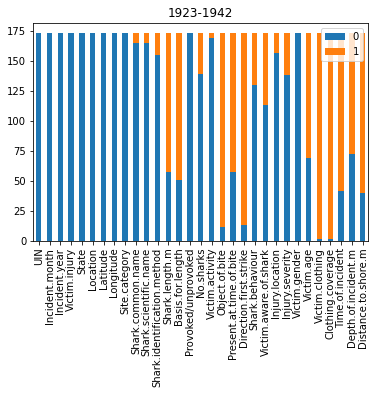

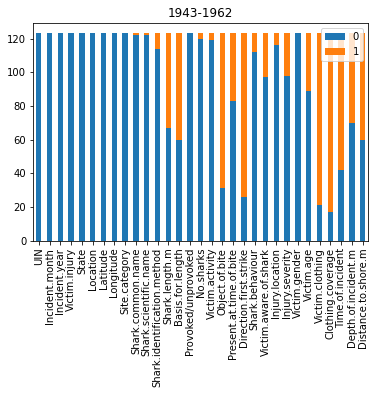

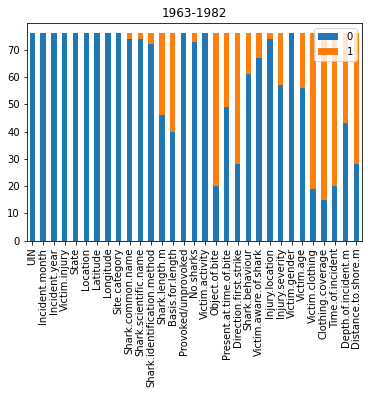

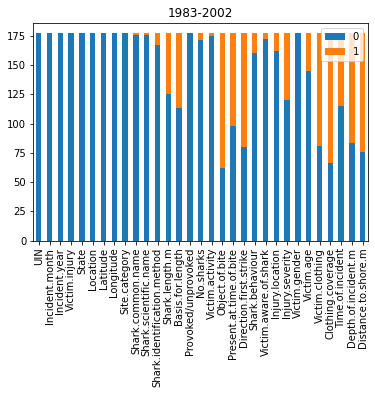

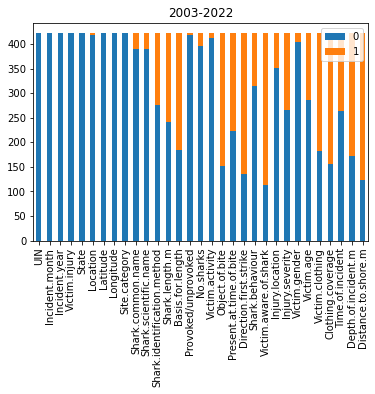

In [9]:
#Graphing the proportion of empty values per variable based on 20 year ranges:
for i in range(5):
    start=1923+(20*i)
    stop=start+19
    section_data=data[data['Incident.year'].between(start, stop)]
    notna_data = pd.DataFrame(columns=section_data.columns)
    notna_data.loc[0]=section_data.notna().sum()
    notna_data.loc[1] = section_data['UIN'].count()-section_data.notna().sum()
    notna_data.T.plot(kind='bar',stacked=True, title = str(start)+'-'+str(stop))

It seems that victim clothing, coverage, awareness and time of incident are recorded in certain year ranges and not others. 
I will save a DataFrame of reliable data for later use:

In [10]:
reliable_data=data[["UIN","Incident.month","Incident.year","Victim.injury","State","Location","Latitude","Longitude","Shark.common.name","Provoked/unprovoked","No.sharks","Victim.activity","Victim.gender","Injury.location"]]
reliable_data=reliable_data.dropna()
reliable_data

,UIN,Incident.month,Incident.year,Victim.injury,State,Location,Latitude,Longitude,Shark.common.name,Provoked/unprovoked,No.sharks,Victim.activity,Victim.gender,Injury.location
220,221.0,1.0,1922.0,injured,NSW,"stockton beach, newcastle",-32.85,151.833333,white shark,unprovoked,1.0,swimming,male,thigh
222,223.0,2.0,1922.0,fatal,NSW,"coogee beach, sydney",-33.91666667,151.250000,white shark,unprovoked,1.0,swimming,male,arm
223,224.0,3.0,1922.0,fatal,NSW,"coogee beach, sydney",-33.91666667,151.250000,white shark,unprovoked,1.0,swimming,male,"hand, torso"
224,225.0,12.0,1922.0,fatal,QLD,"maryborough, pialba beach",-25.53333333,152.700000,tiger shark,unprovoked,1.0,swimming,male,torso
225,226.0,1.0,1923.0,fatal,WA,"swan river, claremont",-31.96666667,115.766667,bull shark,unprovoked,1.0,swimming,male,thigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,1183.0,10.0,2021.0,injured,NSW,moonee beach,-30.2042,153.149000,wobbegong,unprovoked,1.0,boarding,male,foot
1186,1187.0,12.0,2021.0,injured,QLD,"rocky island, yarrabah, far north queensland",-16.9062,145.866200,bull shark,provoked,1.0,spearfishing,male,leg
1187,1188.0,1.0,2022.0,injured,NSW,hyams beach (seamans),-35.1011,150.689200,whaler shark,unprovoked,1.0,swimming,female,"leg, thigh"
1192,1193.0,2.0,2022.0,injured,WA,"wylie bay, esperance",-33.84848,121.918400,white shark,unprovoked,1.0,other:floating,female,torso


## Data Exploration:
### Maps
#### Preparing the data:
I have imported a geomap provided by user [tonywr71 on GitHub](https://raw.githubusercontent.com/tonywr71/GeoJson-Data/master/australian-states.json), as Folium did not have one availible. 

Below, a new dataframe named "chloropleth_data" has been created, containing the list of territory names and their corresponding sum of shark attacks.
<br>The territory abbrevations have been changed to full names, as the provided geomap requires full names.

In [11]:
state_geo = f"https://raw.githubusercontent.com/tonywr71/GeoJson-Data/master/australian-states.json"
data=data.replace({"State": {"NSW":"New South Wales","QLD":"Queensland","WA":"Western Australia", "VIC":"Victoria","SA":"South Australia","NT":"Northern Territory","TAS":"Tasmania"}})

choropleth_data = data["State"].value_counts().to_frame().reset_index()

                index  State
0     New South Wales    357
1          Queensland    284
2   Western Australia    178
3     South Australia     63
4            Victoria     54
5            Tasmania     23
6  Northern Territory     17
976


#### Graphing:
Next, the map is created. 
<br>First, the map is populated with a small red circle for each shark attack. Due to the number of plot points, these circles will overlap; this is fine. The main concern is displaying the concentration of attacks by reigon.
<br>A folium choropleth will be used represent the total number of shark attacks for each reigon, using the prepared data from the cell above.

In [12]:
shark_map = folium.Map(location=[-30, 133.06], zoom_start=4)
for index,a in data.iterrows():
    folium.Marker(location=[a["Latitude"], a["Longitude"]],
                    icon=folium.DivIcon(html=f"""<div><svg>
                        <circle cx="5" cy="5" r="5" stroke="black" stroke-width="1" fill="red" opacity=".5" />
                    </svg></div>""")).add_to(shark_map)
folium.Choropleth(
    geo_data= state_geo,
    name = "Choropleth",
    data = choropleth_data,
    columns=["index","State"],
    key_on="feature.properties.STATE_NAME",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Shark attacks",
).add_to(shark_map)
shark_map

The map above shows that a vast majority of shark attacks occur in New South Wales and Queensland
<br>However, It is important to note that the frequency of shark attacks may be skewed by the the length of coastline and population of each reigon. 
<br>Both will need to be adjusted for in the following:

#### Adjusting for Population and Coastline length

<br>When adjusting for population, I will use the most current populations provided by the Austraian Census (the pop_info dataframe). Since 80% of Australia's population lives within [50km of the coast]('https://www.travellers.com.au/plan-your-trip/australia-facts/#:~:text=Beach%20paradise,of%20our%20laid%2Dback%20lifestyle.'), this value shouldn't be inflated by the area of each State. 
<br>Also note that I am using the current year's population while judging the number of attacks over the past century. This will not provide a rate of shark attacks, and can only used when in comparison to other reigons' values.

,Attacks,Population,Coastline,Attacks_by_pop_100k,Attacks_by_coast_1000km
New South Wales,357,8072163,1973.0,4.422606,180.942727
Queensland,284,5156138,6967.0,5.507998,40.763600
Western Australia,178,2660026,12895.0,6.691664,13.803800
South Australia,63,1781516,3815.0,3.536314,16.513761
Victoria,54,6503491,1870.0,0.830323,28.877005
Tasmania,23,557571,2827.0,4.125035,8.135833
Northern Territory,17,232605,5438.0,7.308527,3.126149


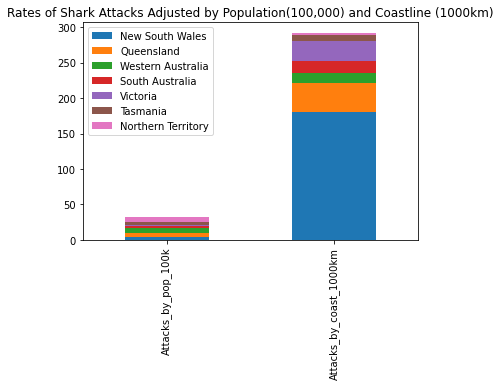

In [13]:
#Creating data_states dataframe:
data_states = data["State"].value_counts().to_frame()
data_states.rename(columns={"State":"Attacks"}, inplace=True)

data_states["Population"] = pop_info["Total"]
data_states["Coastline"] = coast_info["MAINLAND COASTLINE LENGTH"]
data_states["Attacks_by_pop_100k"]=data_states["Attacks"]/(data_states["Population"]/100000)
data_states["Attacks_by_coast_1000km"]=data_states["Attacks"]/(data_states["Coastline"]/1000)
data_states[["Attacks_by_pop_100k","Attacks_by_coast_1000km"]].T.plot(kind='bar',stacked=True, title ="Rates of Shark Attacks Adjusted by Population(100,000) and Coastline (1000km)")
data_states

According to this, the attacks by coastline are much higher for New South Wales than any other reigon of Australia. This number is inflated by a much higher population density in this reigon, as can be seen when looking at the number of attacks by population. This value falls within the small range of other territories, so the number of shark attacks

#### Graphing time of year
The graph below will show the number of attacks depending on time of year:

<AxesSubplot:ylabel='Incident.month'>

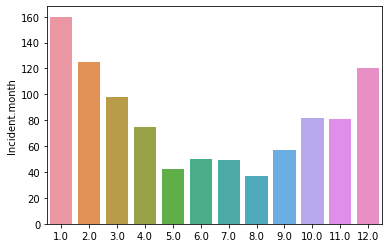

In [20]:
sns.barplot(x=data["Incident.month"].value_counts().index,y=data["Incident.month"].value_counts(),order = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0])

According to this graph, the highest number of shark attacks happen in the Summer: November-February. This makes sense, as many more people would be on the beach during the Summer.

### Injury Analysis:
Here, I will be using the "reliable data" dataset to Analyze what effects the severity of an attack. For this, I will be changing Victim.injury to a numerical value: 
- Uninjured: 0
- Injured: 1
- Fatal: 2

I will also be one-hot encoding the Victim.injury variable. In order to eliminate some disctinctions:
- injury_arm contains arm and shoulder injuries
- injury_leg contains leg, thigh and calf injuries
- injury_ext contains extremities, i.e. hands and feet

In [15]:
#Replace Victim injury with numerical key:
reliable_data["Victim.injury"]=reliable_data["Victim.injury"].apply(lambda x: ['uninjured','injured','fatal'].index(x))
#Replace periods with underscores in column names, as the statsmodel formulas do not like them.
reliable_data.columns = reliable_data.columns.str.replace(".", "_")
#Rename without "/", statsmodel doesn't like those either
reliable_data.rename(columns={"Provoked/unprovoked":"Provoked"},inplace=True)

#From each list of affected body parts in Victim_injury, assign them to a categorical columns  with a 1 for true and a 0 for false
reliable_data["injury_arm"] = reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["arm","shoulder"])))
reliable_data["injury_torso"]= reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["torso"])))
reliable_data["injury_ext"]= reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["hand","foot"])))
reliable_data["injury_pelvic"]= reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["pelvic"])))
reliable_data["injury_leg"]= reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["leg","thigh","calf"])))
reliable_data["injury_head"]= reliable_data["Injury_location"].apply(lambda x: int(any(substring in x for substring in ["head"])))

#misc injury data, will analyze after model
reliable_data["injury_misc_aux"]= reliable_data["injury_arm"]+reliable_data["injury_torso"]+reliable_data["injury_ext"]+reliable_data["injury_pelvic"]+ reliable_data["injury_leg"]+reliable_data["injury_head"]
reliable_data["injury_misc"]=reliable_data["injury_misc_aux"].apply(lambda x: int(x==0))
reliable_data.drop(columns=["injury_misc_aux"], inplace=True)

#Create moel and summary
analysis_rel_1=sm.ols(formula = 'Victim_injury ~ Provoked+Incident_month+State+No_sharks+Victim_gender+Victim_activity', data=reliable_data).fit()
analysis_rel_1.summary()

/tmp/ipykernel_1470/3044288112.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  reliable_data.columns = reliable_data.columns.str.replace(".", "_")


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Victim_injury   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     11.80
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           6.25e-32
Time:                        04:22:32   Log-Likelihood:                -605.14
No. Observations:                 782   AIC:                             1250.
Df Residuals:                     762   BIC:                             1344.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.4005      0.110      3.645      0.000       0.185       0.616
Provoked[T.unprovoked]                          0.2052      0.060      3.447      0.001       0.088       0.322
State[T.NT]                                     0.0531      0.167      0.319      0.750      -0.274       0.380
State[T.QLD]                                    0.0549      0.052      1.054      0.292      -0.047       0.157
State[T.SA]                                     0.3793      0.078      4.839      0.000       0.225       0.533
State[T.TAS]                                    0.1599      0.129      1.244      0.214      -0.092       0.412
State[T.VIC]                                   -0.1703      0.083     -2.041      0.042      -0.334      -0.007
State[T.WA]                                    -0.0170      0.056     -0.305      0.761      -0.126       0.092
Victim_gender[T.male]                           0.0587      0.062      0.942      0.346      -0.064       0.181
Victim_activity[T.diving]                       0.1875      0.081      2.323      0.020       0.029       0.346
Victim_activity[T.fishing]                      0.2605      0.134      1.938      0.053      -0.003       0.524
Victim_activity[T.motorised boating]            0.4660      0.538      0.867      0.386      -0.589       1.521
Victim_activity[T.other: standing in water]     0.2965      0.120      2.464      0.014       0.060       0.533
Victim_activity[T.other:floating]               0.3568      0.538      0.664      0.507      -0.699       1.412
Victim_activity[T.snorkelling]                  0.4994      0.085      5.905      0.000       0.333       0.665
Victim_activity[T.spearfishing]                 0.2754      0.085      3.243      0.001       0.109       0.442
Victim_activity[T.swimming]                     0.5657      0.051     11.024      0.000       0.465       0.666
Victim_activity[T.unmotorised boating]         -0.5552      0.126     -4.392      0.000      -0.803      -0.307
Incident_month                                  0.0075      0.005      1.544      0.123      -0.002       0.017
No_sharks                                       0.0395      0.052      0.763      0.446      -0.062       0.141
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.876
Skew:                           0.034   Prob(JB):                        0.391
Kurtosis:                       2.770   Cond. No.                         208.
==============================================================================

Notes:
[1] Standard Errors assum

This summary tells us a lot:
- F-Statistic: 
    - This statistic tells us how accurate the Null Hypothesis is, or how likely it is that these variables do not effect the Victim Injury value
    - By the provided F-Statistic of 4.13*e^-30, it is incredibly unlikely this is the case.
- P-Value:
    - We are looking for a p-value<.05. If the p-value is higher, it is unlikely that a given variable effects Victim Injury.
    - Values with a valid p-value are:
        - Unprovoked attacks 
        - When the Reigon is South Australia or Victoria
        - Activity is standing in water,diving, swimming, fishing, snorkeling, spear-fishing or Unmotorized Boating
    - Based on these p-values, we can determine with a high degree of confidence that 
        - Unprovoked attacks are more dangerous than provoked attacks
        - South Australia attacks result in the most deadly attacks
        - Victoria tends to lessen the danger of shark attacks for its visitors
        - Unmotorized boating seems to lessen the severity of shark attacks
        
Based on the results of this regression model, I will create another regression model of only injury locations:

In [16]:

analysis_rel_2=sm.ols(formula = 'Victim_injury ~ injury_arm +injury_leg +injury_head +injury_torso +injury_ext +injury_pelvic +injury_misc', data=reliable_data).fit()
analysis_rel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Victim_injury   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     118.1
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.37e-117
Time:                        04:22:32   Log-Likelihood:                -421.93
No. Observations:                 782   AIC:                             859.9
Df Residuals:                     774   BIC:                             897.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9742      0.051     18.975      0.000       0.873       1.075
injury_arm        0.0552      0.046      1.211      0.226      -0.034       0.145
injury_leg        0.2039      0.050      4.074      0.000       0.106       0.302
injury_head      -0.0752      0.105     -0.718      0.473      -0.281       0.130
injury_torso      0.5045      0.053      9.521      0.000       0.400       0.608
injury_ext        0.0209      0.049      0.431      0.667      -0.074       0.116
injury_pelvic    -0.0494      0.085     -0.584      0.559      -0.216       0.117
injury_misc      -0.7681      0.061    -12.644      0.000      -0.887      -0.649
==============================================================================
Omnibus:                      380.930   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1898.820
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                       9.158   Cond. No.                         9.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Of the P-values for this model, it seems that the only injuries that passed the confidence value of .05 were the leg, torso and miscellaneous injuries.
<br>Before creating the final regression model for this section, I'd like to examine what the possible miscellaneous were:

In [17]:
print (reliable_data["Injury_location"].unique())

['thigh' 'arm' 'hand, torso' 'torso' 'other: uninjured' 'leg' 'foot'
 'other: body not recovered' 'arm, torso, foot' 'leg, foot' 'arm, torso'
 'torso, leg' 'hand, pelvic region' 'calf' 'hand, leg, torso' 'arm, hand'
 'leg, hand' 'leg, pelvic region' 'arm, leg, pelvic region'
 'arm, shoulder' 'leg, torso' 'arm, torso, thigh'
 'arm, torso, pelvic region' 'hand, thigh' 'head' 'arm, torso, leg'
 'calf, foot' 'torso, shoulder' 'thigh, calf, foot' 'arm, leg'
 'thigh, torso' 'hand, torso, thigh' 'arm, leg, torso' 'arm, thigh'
 'arm, head, torso' 'torso, pelvic region' 'head, torso' 'thigh, calf'
 'calf, thigh, pelvic region' 'head, shoulder' 'thigh, right' 'hand'
 'head, hand' 'arm, torso, hand, shoulder ' 'arm, foot' 'left foot'
 'pelvic region' 'thigh, pelvic region' 'leg, thigh' 'arm, torso, head'
 'hand, foot' 'left leg']


The only strings that do not fit our model are "other: body not recovered" and "other: uninjured" 
<br>The reason the miscellaneous injuries case seems pretty obvious: those who aren't found are presumed dead, and those uninjured are uninjured. 


<b>Final Regression model:<b>

In [18]:
analysis_rel_3=sm.ols(formula = 'Victim_injury ~ State + Provoked + injury_leg +injury_torso+injury_misc+Victim_activity', data=reliable_data).fit()
analysis_rel_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Victim_injury   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     51.79
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          3.99e-123
Time:                        04:22:32   Log-Likelihood:                -381.78
No. Observations:                 782   AIC:                             803.6
Df Residuals:                     762   BIC:                             896.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.8195      0.054     15.174      0.000       0.713       0.926
State[T.NT]                                    -0.1412      0.125     -1.132      0.258      -0.386       0.104
State[T.QLD]                                    0.0105      0.039      0.271      0.786      -0.066       0.087
State[T.SA]                                     0.1925      0.060      3.218      0.001       0.075       0.310
State[T.TAS]                                    0.2935      0.097      3.025      0.003       0.103       0.484
State[T.VIC]                                   -0.0978      0.063     -1.558      0.120      -0.221       0.025
State[T.WA]                                    -0.0278      0.042     -0.664      0.507      -0.110       0.054
Provoked[T.unprovoked]                          0.1042      0.046      2.290      0.022       0.015       0.194
Victim_activity[T.diving]                       0.1126      0.061      1.855      0.064      -0.007       0.232
Victim_activity[T.fishing]                      0.0467      0.101      0.463      0.643      -0.151       0.245
Victim_activity[T.motorised boating]            0.0731      0.405      0.181      0.857      -0.721       0.868
Victim_activity[T.other: standing in water]     0.0095      0.091      0.105      0.917      -0.169       0.188
Victim_activity[T.other:floating]              -0.2783      0.404     -0.689      0.491      -1.071       0.515
Victim_activity[T.snorkelling]                  0.2178      0.064      3.408      0.001       0.092       0.343
Victim_activity[T.spearfishing]                 0.1485      0.064      2.316      0.021       0.023       0.274
Victim_activity[T.swimming]                     0.2744      0.040      6.841      0.000       0.196       0.353
Victim_activity[T.unmotorised boating]         -0.1734      0.096     -1.805      0.072      -0.362       0.015
injury_leg                                      0.1352      0.035      3.903      0.000       0.067       0.203
injury_torso                                    0.3824      0.047      8.123      0.000       0.290       0.475
injury_misc                                    -0.7551      0.043    -17.555      0.000      -0.840      -0.671
==============================================================================
Omnibus:                      297.793   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1069.348
Skew:                           1.820   Prob(JB):                    6.22e-233
Kurtosis:                       7.423   Cond. No.                         40.3
==============================================================================

Notes:
[1] Standard Errors assum

Note that across the 3 models, log-likelihood has increased dramatically. As a measure of best-fit, this is great news for the model.
<br>
In this final regression model, the values with a valid p-value are:
        - Unprovoked attacks 
        - When the Reigon is South Australia or Tasmania
        - Activity is diving, swimming, snorkeling, spear-fishing. Unmotorized boating fails with a p-value of .7
        - Injuries: leg, torso, misc
Possible errors with this model are that many of the activities are very similar aquatic activities: snorkling is just slow swimming, after all.         
  
Judging by the coefficients, each of these variables' presence increase the severity of injury. The greatest contributors seem to be swimming or snorkling, being in Tasmania, and an injury to the torso. The injury_misc coefficient is far higher than any of these, however it heavily skews the data as one of the possibilities implies a classification of fatality.

### Random Forest Classification:
<br> Below is a random forest classifier for injury severity. A Random Forest randomly generates decision trees out of the given variables, and sorts through them for the most accurate tree.
<br>The hyperparameters were chosen from the regression models, this time leaving out the Injury_misc variable, as it seemed to be against the point
<br>I have also chosen to exclude the State from this model, as it may crowd out other important data.
<br>The statsmodel from the previous section mostly handled categorical variables, but for this section they need to be handled manually.

Recall of random forest model (using test data): 1.0


<AxesSubplot:>

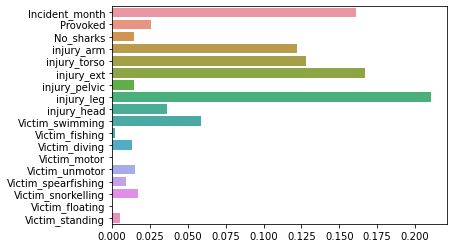

In [19]:
reg_data=reliable_data.drop(columns= ["UIN","Incident_year","Victim_injury","Longitude","State","Latitude","Location","Shark_common_name","Victim_gender","Injury_location","injury_misc"])

#Change the Victim_activity into one-hot encodes
reg_data["Provoked"]=reg_data["Provoked"].apply(lambda x: int(x=="provoked"))
reg_data["Victim_swimming"]=reg_data["Victim_activity"].apply(lambda x: int(x=="swimming"))
reg_data["Victim_fishing"]=reg_data["Victim_activity"].apply(lambda x: int(x=="fishing"))
reg_data["Victim_diving"]=reg_data["Victim_activity"].apply(lambda x: int(x=="diving"))
reg_data["Victim_motor"]=reg_data["Victim_activity"].apply(lambda x: int(x=="motorised boating"))
reg_data["Victim_unmotor"]=reg_data["Victim_activity"].apply(lambda x: int(x=="unmotorised boating"))
reg_data["Victim_spearfishing"]=reg_data["Victim_activity"].apply(lambda x: int(x=="spearfishing"))
reg_data["Victim_snorkelling"]=reg_data["Victim_activity"].apply(lambda x: int(x=="snorkelling"))
reg_data["Victim_floating"]=reg_data["Victim_activity"].apply(lambda x: int(x=="other: floating"))
reg_data["Victim_standing"]=reg_data["Victim_activity"].apply(lambda x: int(x=="other: standing in water"))
#done with this column
reg_data.drop(columns=["Victim_activity"],inplace=True)

#Random Forest model:
X_train, X_test, y_train, y_test = model_selection.train_test_split(reg_data, reliable_data["Victim_injury"], test_size = 0.2)

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
print ('Recall of random forest model (using test data):',metrics.recall_score(y_test, rfc.predict(X_test), average=None)[0])
sns.barplot(x=rfc.feature_importances_, y=reg_data.columns)

Above is the rated importance of each variable by the Random Forest Model that has been generated. This will be different every time it is run, however the variables with the highest importance tend to be month and injury to the leg, followed closely by arm, torso and extremity injuries

### Analysis:
Despite Tasmania having a lower number of shark attacks than most other reigons across all metrics, it is the most hazardous reigon to be attacked. This could be due to its relatively low population and the fact that it is an island. This can make it incredibly difficult to both get noticed and get medical attention.
<br>Diving and Snorkelling being the largest risk-factors out of the victim actvities is unsuprising: the water is where the sharks are, so the more immersed you are the more in danger you are. Diving, despite causing a victim to go far below the ocean surface, involves tethers to a boat and multiple safety precautions before going under. It comes with a higher assumption of danger, and so mitigating the severity of attacks is much more successful.
<br>An injury to the torso is clearly a high risk to your health. The injury or loss of arms, hands and feet can be mitigated, but a torso injury will result in organ damage, and a bite to the leg can cause significant bloodloss from your carotid artery. 
<br>What is most suprising is that in the second regression model, a head injury was ruled as mostly unrelated to the outcome of a shark attack. This may be due to a lack of data where this happened - it is difficult to hit your head in open water.
<br>A shark attack seeming to be unprovoked was reliably an accurate measure of injury. This could be because an unprovoked attack implies the lack of awareness on the part of the victim, and so they were unable to take appropriate action when the shark drew near.
    
### Reccomendation:
If you are terrified of Sharks, Melbourne, Victoria, Australia would be your best bet. In the first regression model, Victoria was implied to have significantly better outcomes for shark attacks when compared to other reigons. These attacks are also least likely to happen to you in Victoria, as the attacks per population was the lowest out of any reigon.

### Ending note:

<br>After this tutorial, you are now familiar with how to manipulate datasets and draw conclusions based on these sets.